*****
*****
# Model Training on Dataset Version 3 (large)
**Multi-label classification dataset (including Binary Classification and Multi-class Classification)**

**Dataset Details:**
- 2602112 samples
- 28 features
- 2 targets
  - 7 different class (1 safe, 6 diffrent malicious)
  - binary class (0-safe, 1-malicous)

*****

In [ ]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install torch
!pip install torchinfo
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

*****
# Necessary Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import time
import json
import copy
import warnings
import joblib

import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve, train_test_split
from sklearn.metrics import(
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, precision_recall_curve, log_loss
)

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

import torch
import optuna
import torch.nn as nn
import torch.optim as optim

from optuna.trial import Trial
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary

import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [ ]:
# check for device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using : {torch.cuda.get_device_name(0) if device.type == 'cuda' else 'cpu'}")

Using : Tesla T4


In [ ]:
np.random.seed(42)
torch.manual_seed(42)

*****
# Dataset Import

In [ ]:
# dataset imports
path = '/content/drive/MyDrive/datasets/v3/'  # global path
X_train = pd.read_csv(path+'X_train.csv')
y_train = pd.read_csv(path+'y_train.csv')
X_test = pd.read_csv(path+'X_test.csv')
y_test = pd.read_csv(path+'y_test.csv')

*****
# Helper Functions

In [ ]:
def measure_time(sec, name, Tune=False):
    """ Measure the time taken for training the model """
    hours, rem = divmod(sec, 3600)
    minutes, seconds = divmod(rem, 60)
    if Tune:
        print(f"{name} Hyperparameter Tuning Time: {int(hours)}h {int(minutes)}m {int(seconds)}s \n")
    else:
        print(f"{name} Training Time: {int(hours)}h {int(minutes)}m {int(seconds)}s \n")


def train_base_model(model, name, X_train, y_train, X_test, y_test):
    """ Train the model and print the training and test accuracy """
    """ Print the training and test accuracy of the model """
    model = MultiOutputClassifier(model)
    model.fit(X_train, y_train)

    train = model.predict(X_train)
    test = model.predict(X_test)

    train_multi = accuracy_score(y_train['Attack Type'], train[:,0])
    train_binary = accuracy_score(y_train['status'], train[:,1])
    test_multi = accuracy_score(y_test['Attack Type'], test[:,0])
    test_acc2 = accuracy_score(y_test['status'], test[:,1])

    print(f"{name} =====================================================")
    print(f"Train Accuracy- Multi-class: {train_multi:.4}, Binary: {train_binary:.4}, Average: {((train_multi+train_binary)/2):.4}")
    print(f"Test Accuracy- Multi-class: {test_multi:.4}, Binary: {test_acc2:.4}, Average: {((test_multi+test_acc2)/2):.4}")


def perform_hyperparameter_tuning(model, parameters, X_train, y_train):
    """ Perform hyperparameter tuning on the model """
    """ Return the best model and best parameters """
    model = MultiOutputClassifier(model)
    grid_search = GridSearchCV(
        estimator= model,
        param_grid=parameters,
        cv=5,
        scoring='accuracy',
        verbose=3,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_

    print("\nBest Parameters:", best_params)
    return best_params

def test_model(model, test_loader, device):
    """ evaluates the trained model on the test dataset for both multi-class and binary classification task. """
    model.eval()  # enable evaluation mode
    correct = 0
    correct_binary = 0
    total = 0

    with torch.no_grad():
        for batch_X, batch_y_multi, batch_y_binary in test_loader:
            batch_X, batch_y_multi, batch_y_binary =  batch_X.to(device), batch_y_multi.to(device), batch_y_binary.to(device)

            # forward pass
            pred_multi, pred_binary = model(batch_X)

            # predictions
            _, predicted_multi = torch.max(pred_multi, 1) # modified remove .data
            predicted_binary = (pred_binary > 0.5).float()

            # calculate accuracy
            correct += (predicted_multi == batch_y_multi).sum().item()
            correct_binary += (predicted_binary == batch_y_binary).sum().item()
            total += batch_y_multi.size(0)

    print(f"Test Multi-class Accuracy: {correct/total:.4f}")
    print(f"Test Binary Accuracy: {correct_binary/total:.4f}")
    print(f"Test Average Accuracy: {((correct/total) + (correct_binary/total)) / 2}")


def get_model_params(model):
    """ returns the number of trainable parameters in the model """
    print(f"Total Number of Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

In [ ]:
def check_metrics(model, name, X_train, y_train, X_test, y_test):
    """ check accuracy, loss, precision, recall, f1-score, tpr, fpr, confusion matrix and precision-recall curve for test data """
    def get_predictions(model, X, y):
        """ get the predictions for the given model one data X & y """
        true_multi = y['Attack Type'].values
        true_binary = y['status'].values

        # get predictions
        pred = model.predict(X)
        pred_multi = pred[:, 0] # multi-class predictions
        pred_binary = pred[:, 1] # binary predictions

        # get probabilities if the model supports
        prob_multi = None
        prob_binary = None
        if hasattr(model, 'predict_proba'):
            proba = model.predict_proba(X)
            prob_multi = proba[0] # multi-class probabilities
            prob_binary = proba[1][:, 1] # binary probabilities

        return pred_multi, pred_binary, true_multi, true_binary, prob_multi, prob_binary

    ## ========================================================================================================= ##
    ## title
    print("="*100)
    print(" "*40 + "\033[1;34m" + name.upper() + " REPORT" + "\033[0m" + " "*10)
    print("="*100)

    ## ========================================================================================================= ##
    # get predictions
    train_pred_multi, train_pred_binary, train_true_multi, train_true_binary, train_prob_multi, train_prob_binary = get_predictions(model, X_train, y_train)
    test_pred_multi, test_pred_binary, test_true_multi, test_true_binary, test_prob_multi, test_prob_binary = get_predictions(model, X_test, y_test)

    # calculate accuracies
    train_acc_multi = accuracy_score(train_true_multi, train_pred_multi)
    train_acc_binary = accuracy_score(train_true_binary, train_pred_binary)
    train_acc_avg = (train_acc_binary + train_acc_multi) / 2
    test_acc_multi = accuracy_score(test_true_multi, test_pred_multi)
    test_acc_binary = accuracy_score(test_true_binary, test_pred_binary)
    test_acc_avg = (test_acc_binary + test_acc_multi) / 2

    # calculate losses
    train_loss_multi = log_loss(train_true_multi, train_prob_multi) if train_prob_multi is not None else float('nan')
    train_loss_binary = log_loss(train_true_binary, train_prob_binary) if train_prob_binary is not None else float('nan')
    train_loss_avg = (train_loss_multi + train_loss_binary) / 2
    test_loss_multi = log_loss(test_true_multi, test_prob_multi) if test_prob_multi is not None else float('nan')
    test_loss_binary = log_loss(test_true_binary, test_prob_binary) if test_prob_binary is not None else float('nan')
    test_loss_avg = (train_loss_multi + train_loss_binary) / 2

    ## ========================================================================================================= ##
    # Print accuracy report
    print("="*100)
    print(f"\n{'':<35} < === Accuracy & Loss Report === >")
    print()
    print(f"{'':<20}   Multi-class  |   Binary   |   Average")
    print(f"Training Accuracy:   {train_acc_multi:10.4f}     |   {train_acc_binary:6.4f}   |   {train_acc_avg:6.4f}")
    print(f"Test Accuracy:       {test_acc_multi:10.4f}     |   {test_acc_binary:6.4f}   |   {test_acc_avg:6.4f}")
    print("                            -       |      -     |      -")
    print(f"Training Loss:       {train_loss_multi:10.4f}     |   {train_loss_binary:6.4f}   |   {train_loss_avg:6.4f}")
    print(f"Test Loss:           {test_loss_multi:10.4f}     |   {test_loss_binary:6.4f}   |   {test_loss_avg:6.4f}")
    print()

    ## ========================================================================================================= ##
    # Binary Classification | test set metrics
    # calculate tpr & fpr for binary classification
    tn, fp, fn, tp = confusion_matrix(test_true_binary, test_pred_binary).ravel()
    tpr_binary = (tp / (tp + fn)).item()
    fpr_binary = (fp / (fp + tn)).item()

    precision_binary = precision_score(test_true_binary, test_pred_binary)
    recall_binary = recall_score(test_true_binary, test_pred_binary)
    f1_binary = f1_score(test_true_binary, test_pred_binary)

    print("="*100)
    print(f"\n{'':<32} < === Binary Classification Report === >")
    print()
    print(f"Precision: {precision_binary:.4f}")
    print(f"Recall: {recall_binary:.4f}")
    print(f"F1 Score: {f1_binary:.4f}")

    print(f"True Positive Rate: {tpr_binary:.4f}")
    print(f"False Positive Rate: {fpr_binary:.4f}")
    print()

    # plot confusion matrix
    cm_binary = confusion_matrix(test_true_binary, test_pred_binary)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues')
    plt.title('Binary Classification Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print()

    # binary precision-recall curve
    if test_prob_binary is not None:
        precision, recall, _ = precision_recall_curve(test_true_binary, test_prob_binary)
        plt.figure(figsize=(6, 4))
        plt.plot(recall, precision, marker='.')
        plt.title('Binary Classification Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.grid(True)
        plt.show()
    else:
        print("Precision-Recall curve for binary classification skipped (model does not support predict_proba)")
    print()

    ## ========================================================================================================= ##
    # Multi-class Classification | test set metrics
    # calculate tpr & fpr for binary classification
    tpr_list = []
    fpr_list = []
    output_class = len(np.unique(test_true_multi))
    for i in range(output_class):
        # convert multiclass labels to binary
        y_true_binary = (test_true_multi == i).astype(int)
        y_pred_binary = (test_pred_multi == i).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_binary).ravel()

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

        tpr_list.append(tpr)
        fpr_list.append(fpr)

    tpr_multi = np.mean(tpr_list).item()
    fpr_multi = np.mean(fpr_list).item()
    precision_multi = precision_score(test_true_multi, test_pred_multi, average='weighted')
    recall_multi = recall_score(test_true_multi, test_pred_multi, average='weighted')
    f1_multi = f1_score(test_true_multi, test_pred_multi, average='weighted')

    print("="*100)
    print(f"\n{'':<26} < === Multi-class Classification Report === >")
    print()
    print(f"Precision: {precision_multi:.4f}")
    print(f"Recall: {recall_multi:.4f}")
    print(f"F1 Score: {f1_multi:.4f}")
    print(f"True Positive Rate: {tpr_multi:.4f}")
    print(f"False Positive Rate: {fpr_multi:.4f}")
    print()

    # plot confusion matrix
    cm_multi = confusion_matrix(test_true_multi, test_pred_multi)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues')
    plt.title('Multi-class Classification Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print()

    # multi-class precision-recall curve
    if test_prob_multi is not None:
        plt.figure(figsize=(8, 5))
        for i in range(output_class):
            # Binarize true labels for class i
            true_binary = (test_true_multi == i).astype(int)
            prob_class = test_prob_multi[:, i]
            precision, recall, _ = precision_recall_curve(true_binary, prob_class)
            plt.plot(recall, precision, label=f"Class {i}")
        plt.title('Multi-class Classification Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(title='class', loc='best')
        plt.grid(True)
        plt.show()
    else:
        print("Precision-Recall curve for binary classification skipped (model does not support predict_proba)")
    print()

    ## ========================================================================================================= ##
    # Average Results | test set metrics


    tpr_avg = ((tpr_binary + tpr_multi) / 2)
    fpr_avg = ((fpr_binary + fpr_multi) / 2)

    precision_avg = (precision_binary + precision_multi) / 2
    recall_avg = (recall_binary + recall_multi) / 2
    f1_avg = (f1_binary + f1_multi) / 2

    print("="*100)
    print(f"\n{'':<30} < === Average Classification Report === >")
    print()
    print(f"Precision: {precision_avg:.4f}")
    print(f"Recall: {recall_avg:.4f}")
    print(f"F1 Score: {f1_avg:.4f}")

    print(f"True Positive Rate: {tpr_avg:.4f}")
    print(f"False Positive Rate: {fpr_avg:.4f}")
    print("="*100)

    # return 3 tuples -> binary_classification_report, multi_classification_report, avg_classification_report
    return ((train_acc_binary, test_acc_binary, train_loss_binary, test_loss_binary, f1_binary, precision_binary, recall_binary, tpr_binary, fpr_binary),
            (train_acc_multi, test_acc_multi, train_loss_multi, test_loss_multi, f1_multi, precision_multi, recall_multi, tpr_multi, fpr_multi),
            (train_acc_avg, test_acc_avg, train_loss_avg, test_loss_avg, f1_avg, precision_avg, recall_avg, tpr_avg, fpr_avg))

def evaluate_dnn_result(model, name, train_loader, test_loader, output_class, device):
    """ evaluate the deep neural network model on training, and test set for mlp and cnn models """
    """ print the training, and test set accuracy first """
    """ print the classification report (accuracy, precision, recall, f1-score, tpr, fpr), confusion matrix
        and precision-recall curve for multi-class and binary classification """

    def get_prediction(loader):
        """ get the predicitons for the model """
        total_pred_multi = []
        total_pred_binary = []
        total_true_multi = []
        total_true_binary = []
        total_prob_multi = []
        total_prob_binary = []

        model.eval()  # enable evaluation mode
        with torch.no_grad():
            for batch_X, batch_y_multi, batch_y_binary in loader:
                batch_X, batch_y_multi, batch_y_binary =  batch_X.to(device), batch_y_multi.to(device), batch_y_binary.to(device)

                # forward pass
                pred_multi, pred_binary = model(batch_X)

                # prediction
                _, predicted_multi = torch.max(pred_multi, 1) # modified remove .data
                predicted_binary = (pred_binary > 0.5).float()

                # move to cpu and convert to numpy
                total_pred_multi.extend(predicted_multi.cpu().numpy())
                total_pred_binary.extend(predicted_binary.cpu().numpy().flatten())
                total_true_multi.extend(batch_y_multi.cpu().numpy())
                total_true_binary.extend(batch_y_binary.cpu().numpy().flatten())
                total_prob_multi.extend(torch.softmax(pred_multi, dim=1).cpu().numpy())
                total_prob_binary.extend(pred_binary.cpu().numpy().flatten())

        return np.array(total_pred_multi), np.array(total_pred_binary), np.array(total_true_multi), np.array(total_true_binary), np.array(total_prob_multi), np.array(total_prob_binary)


    ## ========================================================================================================= ##
    ## title
    print("="*100)
    print(" "*40 + "\033[1;34m" + name.upper() + " REPORT" + "\033[0m" + " "*10)
    print("="*100)

    ## ========================================================================================================= ##
    # get predictions
    train_pred_multi, train_pred_binary, train_true_multi, train_true_binary, train_prob_multi, train_prob_binary = get_prediction(train_loader)
    test_pred_multi, test_pred_binary, test_true_multi, test_true_binary, test_prob_multi, test_prob_binary = get_prediction(test_loader)

    # calculate accuracies
    train_acc_multi = accuracy_score(train_true_multi, train_pred_multi)
    train_acc_binary = accuracy_score(train_true_binary, train_pred_binary)
    train_acc_avg = (train_acc_binary + train_acc_multi) / 2
    test_acc_multi = accuracy_score(test_true_multi, test_pred_multi)
    test_acc_binary = accuracy_score(test_true_binary, test_pred_binary)
    test_acc_avg = (test_acc_binary + test_acc_multi) / 2

    # calculate losses
    train_loss_multi = log_loss(train_true_multi, train_prob_multi) if train_prob_multi is not None else float('nan')
    train_loss_binary = log_loss(train_true_binary, train_prob_binary) if train_prob_binary is not None else float('nan')
    train_loss_avg = (train_loss_multi + train_loss_binary) / 2
    test_loss_multi = log_loss(test_true_multi, test_prob_multi) if test_prob_multi is not None else float('nan')
    test_loss_binary = log_loss(test_true_binary, test_prob_binary) if test_prob_binary is not None else float('nan')
    test_loss_avg = (train_loss_multi + train_loss_binary) / 2

    ## ========================================================================================================= ##
    # Print accuracy report
    print("="*100)
    print(f"\n{'':<35} < === Accuracy & Loss Report === >")
    print()
    print(f"{'':<20}   Multi-class  |   Binary   |   Average")
    print(f"Training Accuracy:   {train_acc_multi:10.4f}     |   {train_acc_binary:6.4f}   |   {train_acc_avg:6.4f}")
    print(f"Test Accuracy:       {test_acc_multi:10.4f}     |   {test_acc_binary:6.4f}   |   {test_acc_avg:6.4f}")
    print("                            -       |      -     |      -")
    print(f"Training Loss:       {train_loss_multi:10.4f}     |   {train_loss_binary:6.4f}   |   {train_loss_avg:6.4f}")
    print(f"Test Loss:           {test_loss_multi:10.4f}     |   {test_loss_binary:6.4f}   |   {test_loss_avg:6.4f}")
    print()

    ## ========================================================================================================= ##
    # Binary Classification | test set metrics
    # calculate tpr & fpr for binary classification
    tn, fp, fn, tp = confusion_matrix(test_true_binary, test_pred_binary).ravel()
    tpr_binary = (tp / (tp + fn)).item()
    fpr_binary = (fp / (fp + tn)).item()

    precision_binary = precision_score(test_true_binary, test_pred_binary)
    recall_binary = recall_score(test_true_binary, test_pred_binary)
    f1_binary = f1_score(test_true_binary, test_pred_binary)

    print("="*100)
    print(f"\n{'':<32} < === Binary Classification Report === >")
    print()
    print(f"Precision: {precision_binary:.4f}")
    print(f"Recall: {recall_binary:.4f}")
    print(f"F1 Score: {f1_binary:.4f}")

    print(f"True Positive Rate: {tpr_binary:.4f}")
    print(f"False Positive Rate: {fpr_binary:.4f}")
    print()

    # plot confusion matrix
    cm_binary = confusion_matrix(test_true_binary, test_pred_binary)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues')
    plt.title('Binary Classification Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print()

    # binary precision-recall curve
    if test_prob_binary is not None:
        precision, recall, _ = precision_recall_curve(test_true_binary, test_prob_binary)
        plt.figure(figsize=(6, 4))
        plt.plot(recall, precision, marker='.')
        plt.title('Binary Classification Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.grid(True)
        plt.show()
    else:
        print("Precision-Recall curve for binary classification skipped (model does not support predict_proba)")
    print()

    ## ========================================================================================================= ##
    # Multi-class Classification | test set metrics
    # calculate tpr & fpr for binary classification
    tpr_list = []
    fpr_list = []
    output_class = len(np.unique(test_true_multi))
    for i in range(output_class):
        # convert multiclass labels to binary
        y_true_binary = (test_true_multi == i).astype(int)
        y_pred_binary = (test_pred_multi == i).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_true_binary, y_pred_binary).ravel()

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

        tpr_list.append(tpr)
        fpr_list.append(fpr)

    tpr_multi = np.mean(tpr_list).item()
    fpr_multi = np.mean(fpr_list).item()
    precision_multi = precision_score(test_true_multi, test_pred_multi, average='weighted')
    recall_multi = recall_score(test_true_multi, test_pred_multi, average='weighted')
    f1_multi = f1_score(test_true_multi, test_pred_multi, average='weighted')

    print("="*100)
    print(f"\n{'':<26} < === Multi-class Classification Report === >")
    print()
    print(f"Precision: {precision_multi:.4f}")
    print(f"Recall: {recall_multi:.4f}")
    print(f"F1 Score: {f1_multi:.4f}")
    print(f"True Positive Rate: {tpr_multi:.4f}")
    print(f"False Positive Rate: {fpr_multi:.4f}")
    print()

    # plot confusion matrix
    cm_multi = confusion_matrix(test_true_multi, test_pred_multi)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues')
    plt.title('Multi-class Classification Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    print()

    # multi-class precision-recall curve
    if test_prob_multi is not None:
        plt.figure(figsize=(8, 5))
        for i in range(output_class):
            # Binarize true labels for class i
            true_binary = (test_true_multi == i).astype(int)
            prob_class = test_prob_multi[:, i]
            precision, recall, _ = precision_recall_curve(true_binary, prob_class)
            plt.plot(recall, precision, label=f"Class {i}")
        plt.title('Multi-class Classification Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(title='class', loc='best')
        plt.grid(True)
        plt.show()
    else:
        print("Precision-Recall curve for binary classification skipped (model does not support predict_proba)")
    print()

    ## ========================================================================================================= ##
    # Average Results | test set metrics


    tpr_avg = ((tpr_binary + tpr_multi) / 2)
    fpr_avg = ((fpr_binary + fpr_multi) / 2)

    precision_avg = (precision_binary + precision_multi) / 2
    recall_avg = (recall_binary + recall_multi) / 2
    f1_avg = (f1_binary + f1_multi) / 2

    print("="*100)
    print(f"\n{'':<30} < === Average Classification Report === >")
    print()
    print(f"Precision: {precision_avg:.4f}")
    print(f"Recall: {recall_avg:.4f}")
    print(f"F1 Score: {f1_avg:.4f}")

    print(f"True Positive Rate: {tpr_avg:.4f}")
    print(f"False Positive Rate: {fpr_avg:.4f}")
    print("="*100)

    # return 3 tuples -> binary_classification_report, multi_classification_report, avg_classification_report
    return ((train_acc_binary, test_acc_binary, train_loss_binary, test_loss_binary, f1_binary, precision_binary, recall_binary, tpr_binary, fpr_binary),
            (train_acc_multi, test_acc_multi, train_loss_multi, test_loss_multi, f1_multi, precision_multi, recall_multi, tpr_multi, fpr_multi),
            (train_acc_avg, test_acc_avg, train_loss_avg, test_loss_avg, f1_avg, precision_avg, recall_avg, tpr_avg, fpr_avg))

In [ ]:
def plot_learning_curve(model, X, y, name, version):
    """ get the model & dataset calculate the training and cross validation losses and plot the learning curve """
    def custom_neg_log_loss(model, X, y):
        """ custom loss function to calculate the negative log loss """
        y_pred_proba = model.predict_proba(X) # get probabilities
        total_loss = 0
        for i, y_label in enumerate(y.columns):
            y_pred = np.clip(y_pred_proba[i], 1e-15, 1 - 1e-15) # get the probabilities of both labels per iterations
            # calculate loss of both label per iterations
            loss = log_loss(y[y_label], y_pred)
            total_loss += loss
        return -total_loss / len(y.columns) # return the average loss

    # get loss values
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X,
        y,
        cv=5,
        scoring= custom_neg_log_loss,
        train_sizes = np.linspace(0.1, 1.0, 50)
    )

    train_losses = -train_scores.mean(axis=1)
    val_losses = -val_scores.mean(axis=1)
    #train_std = train_scores.std(axis=1)
    #val_std = val_scores.std(axis=1)

    # debuging statements
    #print("Train size:", train_sizes)
    print("Train loss:", round(train_losses[-1], 4))
    print("Val loss:", round(val_losses[-1], 4))

    # ploting the learning curve
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_losses, label='Training Loss')
    plt.plot(train_sizes, val_losses, label='Validation Loss (CV)')
    #plt.fill_between(train_sizes, train_losses - train_std, train_losses + train_std, alpha=0.1)
    #plt.fill_between(train_sizes, val_losses - val_std, val_losses + val_std, alpha=0.1)
    plt.title(f"{name} Learning Curve ({version})")
    plt.xlabel("Training Set Size")
    plt.ylabel("Losses")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_learning_curves(history, name, version):
    """ get the model history data as dictionary and plot the learning curve (loss & accuracy curves) """
    plt.figure(figsize=(8, 6))
    plt.plot(history['train_losses'], label='Train Loss')
    plt.plot(history['val_losses'], label='Validation Loss')
    plt.title(f"{name} Learning Curve ({version})")
    plt.xlabel("Epochs")
    plt.ylabel('Losses')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print()
    plt.figure(figsize=(8, 6))
    plt.plot(history['train_acc_multi'], label='Train Multi-class Acc')
    plt.plot(history['val_acc_multi'], label='Val Multi-class Acc')
    plt.plot(history['train_acc_binary'], label='Train Binary Acc')
    plt.plot(history['val_acc_binary'], label='Val Binary Acc')
    plt.plot(history['train_acc_avg'], label='Train Avg Acc')
    plt.plot(history['val_acc_avg'], label='Val Avg Acc')
    plt.title(f"{name} Accuracy Curve ({version})")
    plt.xlabel("Epochs")
    plt.ylabel('Losses')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_training_curve(history):
    """ plot the learning curve of the final dnn """
    plt.figure(figsize=(8,6))
    plt.plot(history['train_losses'], label="Training Loss")
    plt.plot(history['train_acc_multi'], label='Train Multi-class Acc')
    plt.plot(history['train_acc_binary'], label='Train Binary Acc')
    plt.plot(history['train_acc_avg'], label='Train Avg Acc')
    plt.title(f"Deep Neural Network Training Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy/Losses")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def save_classification_reports(binary, multi, average, model_name, file_name):
    """ save the classification results into a json file """
    metrics = ["Train Acc", "Test Acc", "Train Loss", "Test Loss", "F1-score", "Precision", "Recall", "TPR", "FPR"]   # define the metrics keys

    # unpack the tuples
    binary_dict = {key: round(value, 4) for key, value in zip(metrics, binary)}
    multi_dict = {key: round(value, 4) for key, value in zip(metrics, multi)}
    avg_dict = {key: round(value, 4) for key, value in zip(metrics, average)}

    # structure the data
    model_data = {
        model_name: {
            "Binary Classification Results": binary_dict,
            "Multi-class Classification Results": multi_dict,
            "Average Classification Results": avg_dict
        }
    }
    try:
        if os.path.exists(file_name):  # check for file exists
            with open(file_name, 'r') as file:
                existing_data = json.load(file)
            existing_data.update(model_data)
        else:
            existing_data = model_data
        with open(file_name, 'w') as file:
            json.dump(existing_data, file, indent=4)
        print("Data saved successfully!")
    except Exception as e:
        print("Data not save!",e)

# Train base model on training set and evaluate on Test set. (Decision Tree, Random Forest, Naive Bayes)
printing the Training and Test set accuracy for each models.

In [ ]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(),
}

for name, model in models.items():
  start = time.time()
  train_base_model(model, name, X_train, y_train, X_test, y_test)
  end = time.time()
  measure_time((end-start), name)

Decision Tree =====================================================
Train Accuracy- Multi-class: 0.9825, Binary: 0.9825, Average: 0.9825
Test Accuracy- Multi-class: 0.9755, Binary: 0.976, Average: 0.9757
Decision Tree Training Time: 0h 1m 31s 

Random Forest =====================================================
Train Accuracy- Multi-class: 0.9825, Binary: 0.9825, Average: 0.9825
Test Accuracy- Multi-class: 0.9758, Binary: 0.9762, Average: 0.976
Random Forest Training Time: 0h 26m 20s 

Naive Bayes =====================================================
Train Accuracy- Multi-class: 0.5878, Binary: 0.7029, Average: 0.6453
Test Accuracy- Multi-class: 0.5859, Binary: 0.7018, Average: 0.6438
Naive Bayes Training Time: 0h 0m 8s 

AdaBoost =====================================================
Train Accuracy- Multi-class: 0.7166, Binary: 0.9445, Average: 0.8306
Test Accuracy- Multi-class: 0.7167, Binary: 0.9441, Average: 0.8304
AdaBoost Training Time: 0h 8m 14s 



*****
*****
# Decision Tree

In [ ]:
# performing hyperparameter tuning for Decision Tree model
dt_param_grid = {
    'estimator__criterion': ['gini'],
    'estimator__max_depth': [10, 20, 30],
    'estimator__min_samples_split': [2, 4],
    'estimator__min_samples_leaf': [1, 2, 4]
}

start = time.time()
dt_best_params = perform_hyperparameter_tuning(
    DecisionTreeClassifier(random_state=42),
    dt_param_grid,
    X_train,
    y_train
)
measure_time((time.time()-start), "Decision Tree", True)

Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best Parameters: {'estimator__criterion': 'gini', 'estimator__max_depth': 10, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2}
Decision Tree Hyperparameter Tuning Time: 1h 26m 47s 



Train loss: 0.1041
Val loss: 0.1045


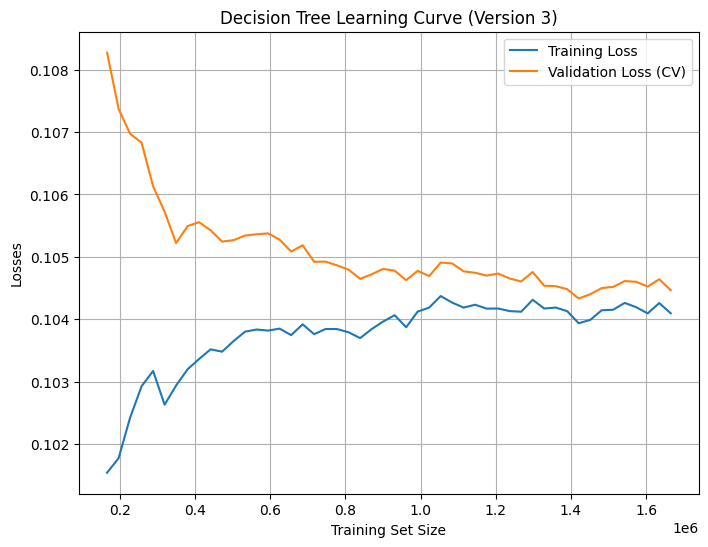

In [ ]:
# initialize the classifier
#dt_best_params = {key.replace('estimator__', ''): value for key, value in dt_best_params.items()}
#dt_classifier = MultiOutputClassifier(DecisionTreeClassifier(**dt_best_params, ccp_alpha=0.0001, random_state=42))
dt_classifier = MultiOutputClassifier(DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=2, criterion='gini', ccp_alpha=0.0001, random_state=42))

# ploting learning curve
plot_learning_curve(dt_classifier, X_train, y_train, 'Decision Tree', "Version 3")


                                        DECISION TREE REPORT          

                                    < === Accuracy & Loss Report === >

                       Multi-class  |   Binary   |   Average
Training Accuracy:       0.9662     |   0.9667   |   0.9665
Test Accuracy:           0.9660     |   0.9667   |   0.9663
                            -       |      -     |      -
Training Loss:           0.1133     |   0.0966   |   0.1049
Test Loss:               0.1141     |   0.0966   |   0.1049


                                 < === Binary Classification Report === >

Precision: 0.9711
Recall: 0.9539
F1 Score: 0.9624
True Positive Rate: 0.9539
False Positive Rate: 0.0230



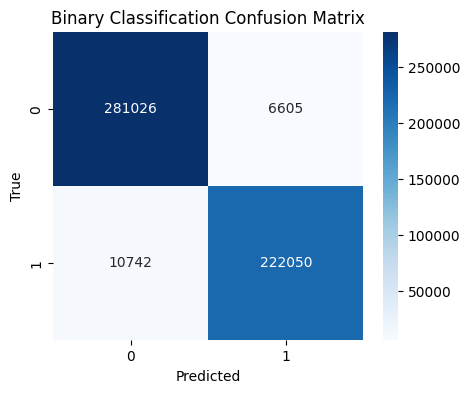

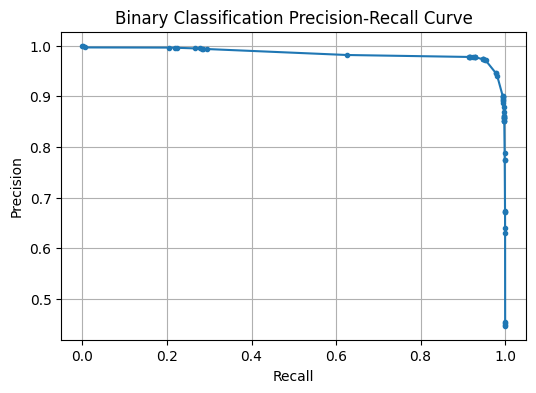



                           < === Multi-class Classification Report === >

Precision: 0.9665
Recall: 0.9660
F1 Score: 0.9656
True Positive Rate: 0.9471
False Positive Rate: 0.0094



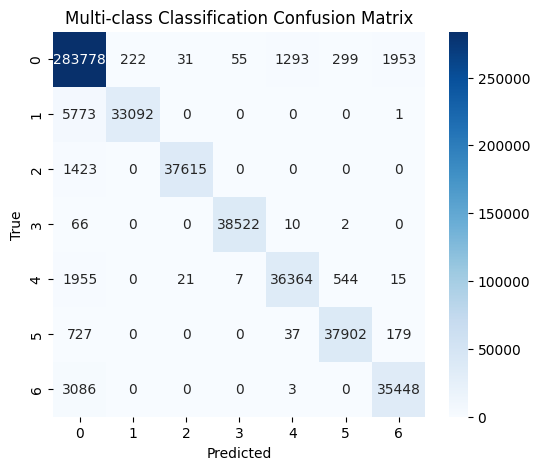

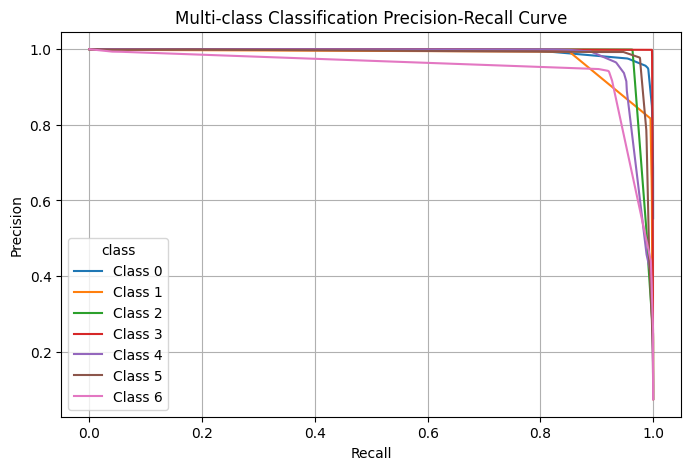



                               < === Average Classification Report === >

Precision: 0.9688
Recall: 0.9599
F1 Score: 0.9640
True Positive Rate: 0.9505
False Positive Rate: 0.0162


In [ ]:
# train the final model
dt_classifier.fit(X_train, y_train)

# evaluate the final model on test set & get the loss and accuracy of training set
binary_classification_report, multi_classification_report, avg_classification_report = check_metrics(dt_classifier, "Decision Tree", X_train, y_train, X_test, y_test)

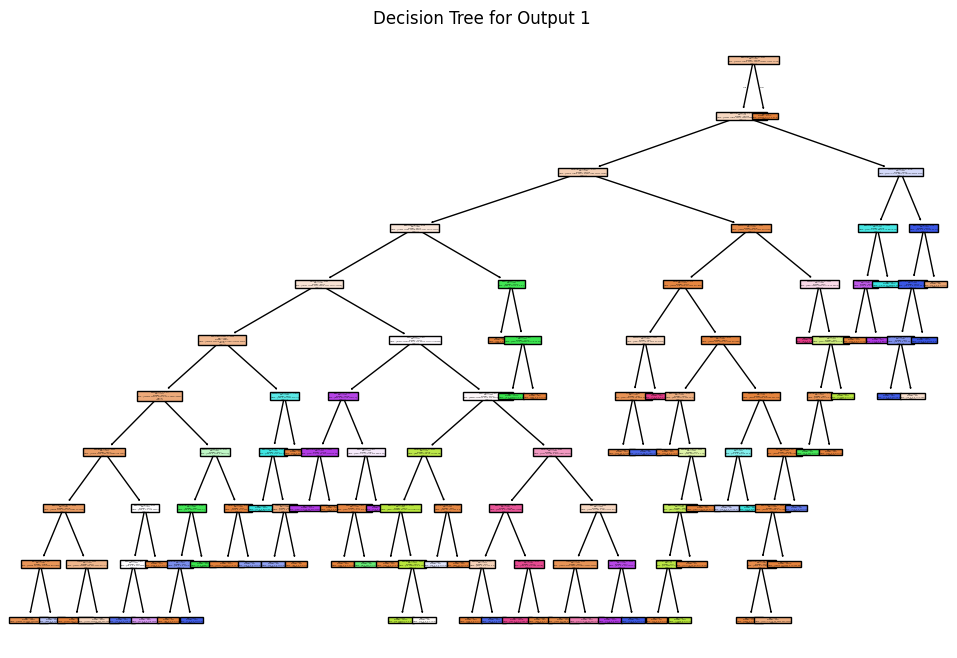

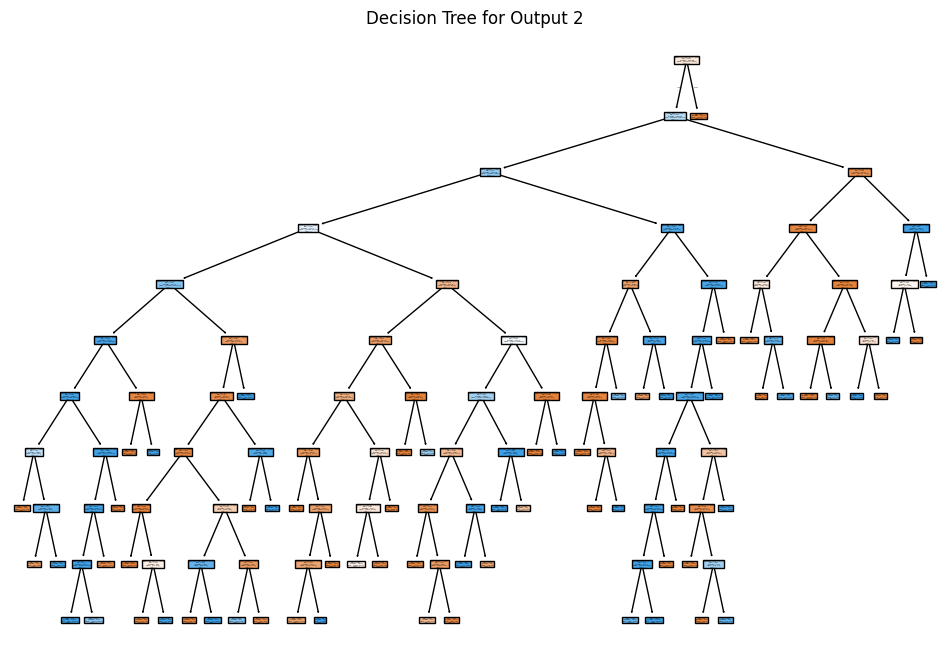

In [ ]:
from sklearn.tree import plot_tree

for i, tree in enumerate(dt_classifier.estimators_):
    plt.figure(figsize=(12, 8))

    class_names = [str(cls) for cls in tree.classes_] if hasattr(tree, "classes_") else None
    feature_names = X_train.columns if hasattr(X_train, "columns") else [f"Feature {j}" for j in range(X_train.shape[1])]

    plot_tree(tree, filled=True, feature_names=feature_names, class_names=class_names)
    plt.title(f"Decision Tree for Output {i+1}")
    plt.show()

In [ ]:
# write into json file
save_classification_reports(binary_classification_report, multi_classification_report, avg_classification_report, "Decision Tree V3", (path + "v3_results.json"))

Data saved successfully!


In [ ]:
# saving model
joblib.dump(dt_classifier, (path + 'dt_classifier_v3.pkl'))

['/content/drive/MyDrive/datasets/v3/dt_classifier_v3.pkl']

*****
*****
# Random Forest

In [ ]:
# performing hyperparameter tuning for Random Forest model
rf_param_grid = {
    'estimator__n_estimators': [50, 100, 150],
    'estimator__max_depth': [10, 20, 30],
    'estimator__min_samples_split': [2, 4],
    'estimator__min_samples_leaf': [1, 2, 4],
    'estimator__criterion': ['gini']
}
start = time.time()
rf_best_params = perform_hyperparameter_tuning(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    X_train,
    y_train
)
measure_time((time.time()-start), "Random Foorest", True)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [ ]:
# initialize the classifier
#rf_best_params = {key.replace('estimator__', ''): value for key, value in rf_best_params.items()}
#rf_classifier = MultiOutputClassifier(RandomForestClassifier(**rf_best_params, ccp_alpha=0.0001, random_state=42))
start = time.time()
rf_classifier = MultiOutputClassifier(RandomForestClassifier(max_depth=10, min_samples_split=2, min_samples_leaf=1, n_estimators=50, criterion='gini', ccp_alpha=0.0001, random_state=42))
measure_time((time.time()-start), "Random Forest")

# ploting learning curve
# plot_learning_curve(rf_classifier, X_train, y_train, 'Random Forest', "Version 3")

Random Forest Training Time: 0h 0m 0s 



                                        RANDOM FOREST REPORT          

                                    < === Accuracy & Loss Report === >

                       Multi-class  |   Binary   |   Average
Training Accuracy:       0.9718     |   0.9719   |   0.9719
Test Accuracy:           0.9716     |   0.9716   |   0.9716
                            -       |      -     |      -
Training Loss:           0.0983     |   0.0795   |   0.0889
Test Loss:               0.0987     |   0.0799   |   0.0889


                                 < === Binary Classification Report === >

Precision: 0.9849
Recall: 0.9511
F1 Score: 0.9677
True Positive Rate: 0.9511
False Positive Rate: 0.0118



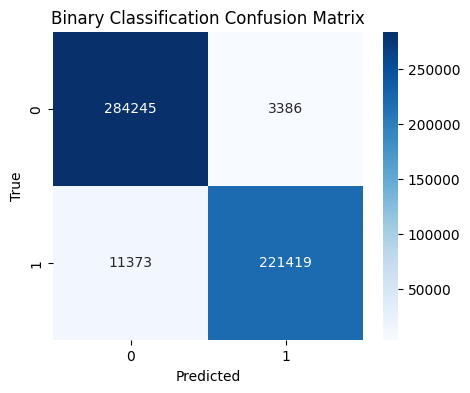

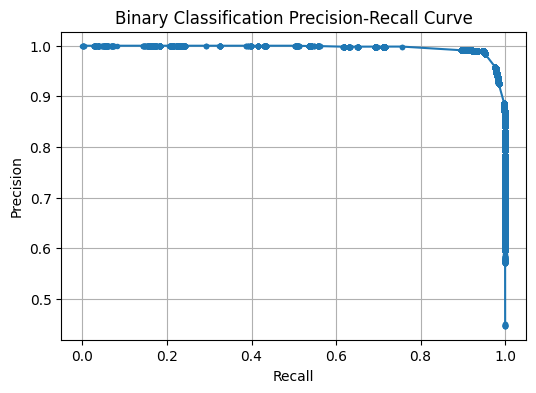



                           < === Multi-class Classification Report === >

Precision: 0.9721
Recall: 0.9716
F1 Score: 0.9713
True Positive Rate: 0.9534
False Positive Rate: 0.0081



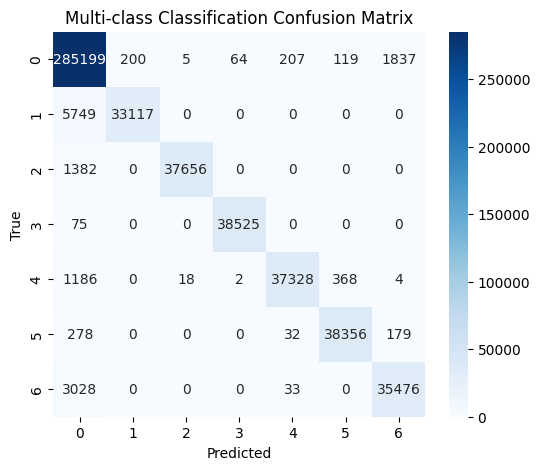

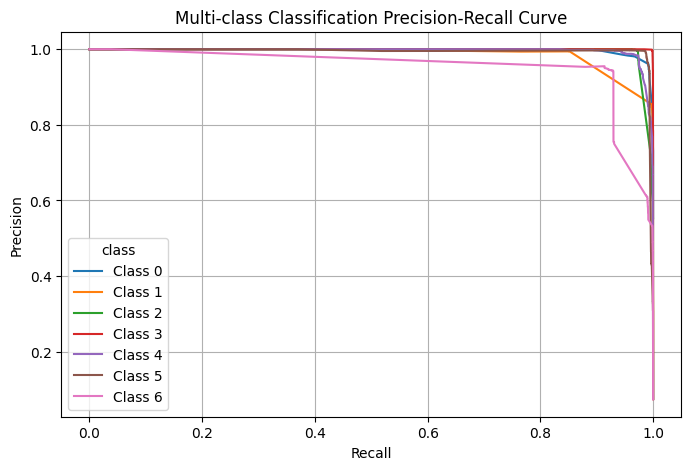



                               < === Average Classification Report === >

Precision: 0.9785
Recall: 0.9614
F1 Score: 0.9695
True Positive Rate: 0.9523
False Positive Rate: 0.0099


In [ ]:
# train the final model
rf_classifier.fit(X_train, y_train)

# evaluate the final model on test set & get the loss and accuracy of training set
binary_classification_report_rf, multi_classification_report_rf, avg_classification_report_rf = check_metrics(rf_classifier, "Random Forest", X_train, y_train, X_test, y_test)

In [ ]:
# write into json file
save_classification_reports(binary_classification_report_rf, multi_classification_report_rf, avg_classification_report_rf, "Random Forest V3", (path + "v3_results.json"))

Data saved successfully!


In [ ]:
# saving model
joblib.dump(rf_classifier, (path + 'rf_classifier_v3.pkl'))

['/content/drive/MyDrive/datasets/v3/rf_classifier_v3.pkl']

*****
*****
# Naive Bayes

In [ ]:
"""
# performing hyperparameter tuning for Naive Bayes model
nb_param_grid = {
    "estimator__var_smoothing": [10**exp for exp in np.arange(-20, -5.1, 1)]
}

start = time.time()
nb_best_params = perform_hyperparameter_tuning(
    GaussianNB(),
    nb_param_grid,
    X_train,
    y_train
)
measure_time((time.time()-start), "Naive Bayes", True)
"""

'\n# performing hyperparameter tuning for Naive Bayes model\nnb_param_grid = {\n    "estimator__var_smoothing": [10**exp for exp in np.arange(-20, -5.1, 1)]\n}\n\nstart = time.time()\nnb_best_params = perform_hyperparameter_tuning(\n    GaussianNB(),\n    nb_param_grid,\n    X_train,\n    y_train\n)\nmeasure_time((time.time()-start), "Naive Bayes", True)\n'

In [ ]:
# initialize the classifier
#nb_best_params = {key.replace('estimator__', ''): value for key, value in nb_best_params.items()}
#nb_classifier = MultiOutputClassifier(GaussianNB(**nb_best_params))
nb_classifier = MultiOutputClassifier(GaussianNB(var_smoothing=1e-20))

# ploting learning curve
# plot_learning_curve(nb_classifier, X_train, y_train, 'Naive Bayes', "Version 3")

                                        NAIVE BAYES REPORT          

                                    < === Accuracy & Loss Report === >

                       Multi-class  |   Binary   |   Average
Training Accuracy:       0.6520     |   0.7007   |   0.6764
Test Accuracy:           0.6502     |   0.6998   |   0.6750
                            -       |      -     |      -
Training Loss:          10.8174     |   9.5204   |   10.1689
Test Loss:              10.8667     |   9.5687   |   10.1689


                                 < === Binary Classification Report === >

Precision: 0.5998
Recall: 0.9883
F1 Score: 0.7465
True Positive Rate: 0.9883
False Positive Rate: 0.5338



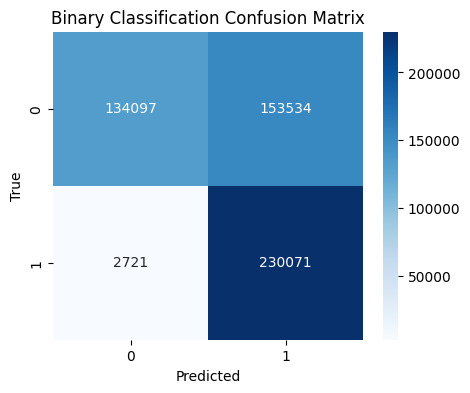

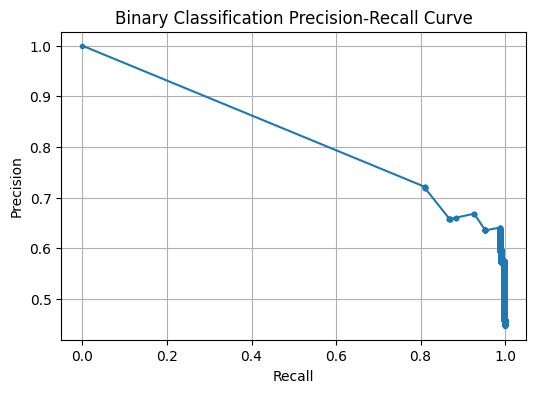



                           < === Multi-class Classification Report === >

Precision: 0.8160
Recall: 0.6502
F1 Score: 0.6627
True Positive Rate: 0.7119
False Positive Rate: 0.0541



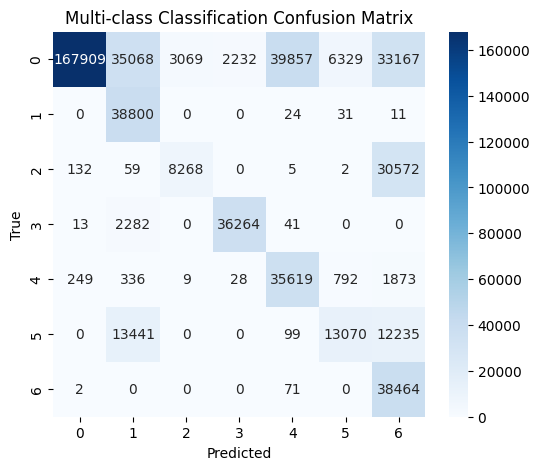

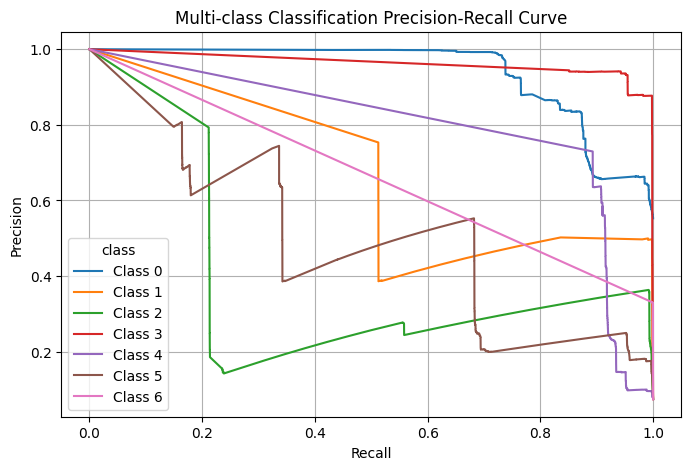



                               < === Average Classification Report === >

Precision: 0.7079
Recall: 0.8193
F1 Score: 0.7046
True Positive Rate: 0.8501
False Positive Rate: 0.2939


In [ ]:
# train the final model
nb_classifier.fit(X_train, y_train)

# evaluate the final model on test set & get the loss and accuracy of training set
binary_classification_report_nb, multi_classification_report_nb, avg_classification_report_nb = check_metrics(nb_classifier, "Naive Bayes", X_train, y_train, X_test, y_test)

In [ ]:
# write into json file
save_classification_reports(binary_classification_report_nb, multi_classification_report_nb, avg_classification_report_nb, "Naive Bayes V3", (path + "v3_results.json"))

Data saved successfully!


In [ ]:
# saving model
joblib.dump(nb_classifier, (path + 'nb_classifier_v3.pkl'))

['/content/drive/MyDrive/datasets/v3/nb_classifier_v3.pkl']

*****
*****
# AdaBoost

In [ ]:
"""
# performing hyperparameter tuning for AdaBoost model
ada_param_grid = {
    'estimator__n_estimators': [50, 100, 150, 200],
    'estimator__learning_rate': [0.001, 0.01, 0.05, 0.1],
}

start = time.time()
ada_best_params = perform_hyperparameter_tuning(
    AdaBoostClassifier(random_state=42),
    ada_param_grid,
    X_train,
    y_train
)
measure_time((time.time()-start), "Ada Boost", True)
"""

'\n# performing hyperparameter tuning for AdaBoost model\nada_param_grid = {\n    \'estimator__n_estimators\': [50, 100, 150, 200],\n    \'estimator__learning_rate\': [0.001, 0.01, 0.05, 0.1],\n}\n\nstart = time.time()\nada_best_params = perform_hyperparameter_tuning(\n    AdaBoostClassifier(random_state=42),\n    ada_param_grid,\n    X_train,\n    y_train\n)\nmeasure_time((time.time()-start), "Ada Boost", True)\n'

In [ ]:
# initialize the classifier
#ada_best_params = {key.replace('estimator__', ''): value for key, value in ada_best_params.items()}
#ada_classifier = MultiOutputClassifier(AdaBoostClassifier(**ada_best_params, random_state=42))
ada_classifier = MultiOutputClassifier(AdaBoostClassifier(n_estimators=50, learning_rate=0.001, random_state=42))

# ploting learning curve
#plot_learning_curve(ada_classifier, X_train, y_train, 'Ada Boost', "Version 3")

                                        ADA BOOST REPORT          

                                    < === Accuracy & Loss Report === >

                       Multi-class  |   Binary   |   Average
Training Accuracy:       0.5534     |   0.7234   |   0.6384
Test Accuracy:           0.5527     |   0.7224   |   0.6376
                            -       |      -     |      -
Training Loss:           1.8685     |   0.6801   |   1.2743
Test Loss:               1.8686     |   0.6821   |   1.2743


                                 < === Binary Classification Report === >

Precision: 0.6171
Recall: 0.9999
F1 Score: 0.7632
True Positive Rate: 0.9999
False Positive Rate: 0.5021



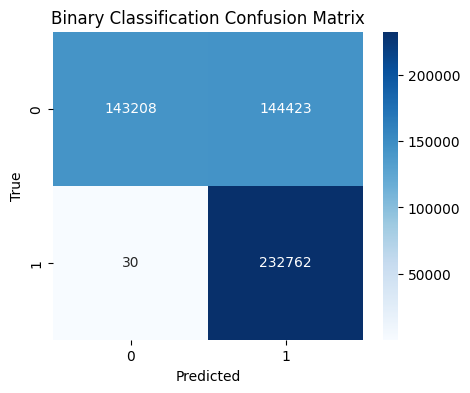

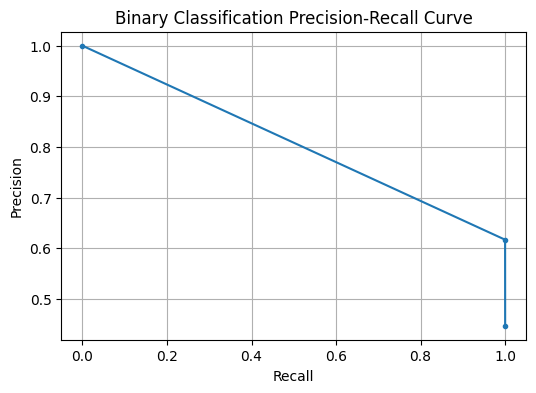



                           < === Multi-class Classification Report === >

Precision: 0.3055
Recall: 0.5527
F1 Score: 0.3935
True Positive Rate: 0.1429
False Positive Rate: 0.1429



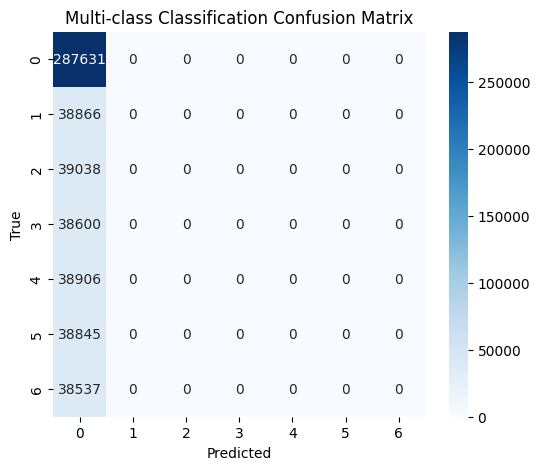

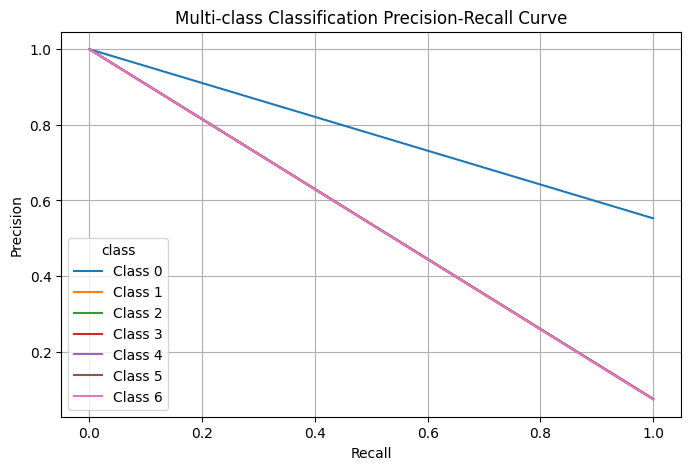



                               < === Average Classification Report === >

Precision: 0.4613
Recall: 0.7763
F1 Score: 0.5783
True Positive Rate: 0.5714
False Positive Rate: 0.3225


In [ ]:
# train the final model
ada_classifier.fit(X_train, y_train)

# evaluate the final model on test set & get the loss and accuracy of training set
binary_classification_report_ada, multi_classification_report_ada, avg_classification_report_ada = check_metrics(ada_classifier, "Ada Boost", X_train, y_train, X_test, y_test)

In [ ]:
# write into json file
save_classification_reports(binary_classification_report_ada, multi_classification_report_ada, avg_classification_report_ada, "Ada Boost V3", (path + "v3_results.json"))

Data saved successfully!


In [ ]:
# saving model
joblib.dump(ada_classifier, (path + 'ada_classifier_v3.pkl'))

['/content/drive/MyDrive/datasets/v3/ada_classifier_v3.pkl']

*****
*****
# Multi Layer Perceptron

### Create Custom Dataset Class for multi-label dataset

In [ ]:
class MultiLabelDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y_multi = torch.LongTensor(y['Attack Type'].values)
        self.y_binary = torch.FloatTensor(y['status'].values).unsqueeze(1)

    def __len__(self):
        return self.X.shape[0] # return the sample size

    def __getitem__(self, idx):
        return self.X[idx], self.y_multi[idx], self.y_binary[idx]

### Creating Dynamic Network

In [ ]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layers, dropout_rate=0.2):
        super(MultiLayerPerceptron, self).__init__()

        layers = []

        # hidden layers
        for _ in range(num_hidden_layers):
            layers.append(nn.Linear(input_dim, neurons_per_layers))
            layers.append(nn.BatchNorm1d(neurons_per_layers))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = neurons_per_layers

        self.network = nn.Sequential(*layers) # create the network

        self.multi_output = nn.Linear(neurons_per_layers, output_dim)   # multiclass output
        self.binary_output = nn.Sequential(   # binary output
            nn.Linear(neurons_per_layers, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.network(x)
        multi_class_out = self.multi_output(features)
        binary_out = self.binary_output(features)
        return multi_class_out, binary_out


### Hyper Parameter Tuning

In [ ]:
def objective(trial, train_dataset, val_dataset, input_dim, output_dim, device):
    # suggested parameters
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 2, 10)
    neurons_per_layers = trial.suggest_int('neurons_per_layers', 32, 512, step=32)
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.5, step=0.05)
    num_epochs = trial.suggest_int('num_epochs', 20, 100, step=20)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    #learning_rate = trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.001, 0.005, 0.0001, 0.0005, 0.00005])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer_name', ['Adam', 'SGD', 'RMSprop'])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # init model
    model = MultiLayerPerceptron(
        input_dim = input_dim,
        output_dim = output_dim,
        num_hidden_layers = num_hidden_layers,
        neurons_per_layers = neurons_per_layers,
        dropout_rate = dropout_rate
    ).to(device)

    # define loss functions and optimizer with weight decay
    criterion_multi = nn.CrossEntropyLoss()
    criterion_binary = nn.BCELoss()

    # select optimizer
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        momentum = trial.suggest_float('momentum', 0.0, 0.9)
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # train the model
    _, history = train_model(
        model = model,
        train_loader = train_loader,
        val_loader = val_loader,
        criterion_multi = criterion_multi,
        criterion_binary = criterion_binary,
        optimizer = optimizer,
        scheduler = scheduler,
        num_epochs = num_epochs,
        device = device,
        tune=True
    )

    # return the best validation loss as the objective to minimize
    best_val_loss = min(history['val_losses'])
    return best_val_loss

In [ ]:
def tune_hyperparameters(train_dataset, val_dataset, input_dim, output_dim, device, n_trials=50):
    """ perform hyperparameter tuning using optuna """
    # create optuna study with minimize validation loss
    study = optuna.create_study(direction='minimize')
    start = time.time()
    study.optimize(
        lambda trial: objective(trial, train_dataset, val_dataset, input_dim, output_dim, device),
        n_trials=n_trials,
        n_jobs=3,
        show_progress_bar=True
    )
    measure_time((time.time()-start), "MLP", True)
    print("Number of finished trials:", len(study.trials))
    print("Best trial: ")
    trial = study.best_trial

    print(f"Validation Loss: {trial.value:4f}")
    print("Best Parameters: ")
    for key, value in trial.params.items():
        print(f" {key}: {value}")

    return study.best_params

### Training Function

In [ ]:
def train_epoch(model, data_loader, criterion_multi, criterion_binary, optimizer=None, is_training=True, device='cuda'):
    """ this function contain the model training evaluation epoch loop to reduce code redundant """
    total_loss = 0
    correct_multi = 0
    correct_binary = 0
    total_samples = 0

    # Set model mode (train or eval)
    model.train() if is_training else model.eval()

    for batch_X, batch_y_multi, batch_y_binary in data_loader:
        batch_X, batch_y_multi, batch_y_binary = batch_X.to(device), batch_y_multi.to(device), batch_y_binary.to(device)

        # forward pass
        pred_multi, pred_binary = model(batch_X)

        # calculate loss
        loss_multi = criterion_multi(pred_multi, batch_y_multi)
        loss_binary = criterion_binary(pred_binary, batch_y_binary)
        loss = loss_multi + loss_binary

        if is_training:
            # bacward pass
            optimizer.zero_grad()
            loss.backward()
            # update grad
            optimizer.step()

        # calculate total epoch loss and accuracy
        total_loss += loss.item()
        _, predicted_multi = torch.max(pred_multi, 1)
        predicted_binary = (pred_binary > 0.5).float()

        correct_multi += (predicted_multi == batch_y_multi).sum().item()
        correct_binary += (predicted_binary == batch_y_binary).sum().item()
        total_samples += batch_y_multi.size(0)

    avg_loss = total_loss / len(data_loader)
    acc_multi = correct_multi / total_samples
    acc_binary = correct_binary / total_samples
    acc_avg = (acc_multi + acc_binary) / 2

    return avg_loss, acc_multi, acc_binary, acc_avg

In [ ]:
def train_model(model, train_loader, val_loader, criterion_multi, criterion_binary, optimizer, scheduler, num_epochs, device, patience=5, tune=False):
    # total training losses & accuracy
    train_losses = []
    train_acc_multi = []
    train_acc_binary = []
    train_acc_avg = []

    # total validation losses and accuracy
    val_losses = []
    val_acc_multi = []
    val_acc_binary = []
    val_acc_avg = []

    best_val_loss = float('inf')
    epochs_no_improve = 0

    # trainig loop
    for epoch in range(num_epochs):
        avg_train_loss, acc_train_multi, acc_train_binary, acc_train_avg = train_epoch(
            model,
            train_loader,
            criterion_multi,
            criterion_binary,
            optimizer=optimizer,
            is_training=True,
            device=device
        )

        # store training metrics
        train_losses.append(avg_train_loss)
        train_acc_multi.append(acc_train_multi)
        train_acc_binary.append(acc_train_binary)
        train_acc_avg.append(acc_train_avg)

        # validation phase
        avg_val_loss, acc_val_multi, acc_val_binary, acc_val_avg = train_epoch(
            model,
            val_loader,
            criterion_multi,
            criterion_binary,
            optimizer=None,
            is_training=False,
            device=device
        )

        # store validation metrics
        val_losses.append(avg_val_loss)
        val_acc_multi.append(acc_val_multi)
        val_acc_binary.append(acc_val_binary)
        val_acc_avg.append(acc_val_avg)

        if tune==False:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Acc Avg: {train_acc_avg[-1]:.4f}, Val Acc Avg: {val_acc_avg[-1]:.4f}, Train Acc Multi: {train_acc_multi[-1]:.4f}, Train Acc Binary: {train_acc_binary[-1]:.4f}, Val Acc Multi: {val_acc_multi[-1]:.4f}, Val Acc Binary: {val_acc_binary[-1]:.4f}")

        # step the scheduler based on validation loss
        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())  # saving the best model weights
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epoch > 10 and epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    model.load_state_dict(best_model_wts)   # loading the best model weights

    history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_acc_multi': train_acc_multi,
        'train_acc_binary': train_acc_binary,
        'train_acc_avg': train_acc_avg,
        'val_acc_multi': val_acc_multi,
        'val_acc_binary': val_acc_binary,
        'val_acc_avg': val_acc_avg
    }
    return model, history


In [ ]:
def train_final_model(model, train_loader, criterion_multi, criterion_binary, optimizer, num_epochs, device):
    """ train the final model on the training dataset only """
    train_losses = []
    train_acc_multi = []
    train_acc_binary = []
    train_acc_avg = []

    # Training loop (no validation)
    for epoch in range(num_epochs):
        avg_train_loss, acc_train_multi, acc_train_binary, acc_train_avg = train_epoch(
            model,
            train_loader,
            criterion_multi,
            criterion_binary,
            optimizer=optimizer,
            is_training=True,
            device=device
        )

        train_losses.append(avg_train_loss)
        train_acc_multi.append(acc_train_multi)
        train_acc_binary.append(acc_train_binary)
        train_acc_avg.append(acc_train_avg)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, "
              f"Train Acc Avg: {acc_train_avg:.4f}, Train Acc Multi: {acc_train_multi:.4f}, Train Acc Binary: {acc_train_binary:.4f}")

    history = {
        'train_losses': train_losses,
        'train_acc_multi': train_acc_multi,
        'train_acc_binary': train_acc_binary,
        'train_acc_avg': train_acc_avg
    }

    return model, history


### Training Phase

In [ ]:
# perform hyper parameter tuning
train_dataset = MultiLabelDataset(X_train, y_train)
test_dataset = MultiLabelDataset(X_test, y_test)

# init parameters
input_size = X_train.shape[1]
output_size = len(np.unique(y_train['Attack Type']))

# start = time.time()
# best_params = tune_hyperparameters(
#     train_dataset,
#     test_dataset,
#     input_size,
#     output_size,
#     device
# )
# measure_time((time.time()-start), "MLP", True)

In [ ]:
# initialize final model with best parameters
model = MultiLayerPerceptron(
    input_dim = input_size,
    output_dim = output_size,
    num_hidden_layers = 5,
    neurons_per_layers = 448,
    dropout_rate = 0.3
).to(device)

# model training with best parameters to track the model lerning performance
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

optimizer = optim.Adam(model.parameters(), lr=0.0002805098974448529, weight_decay=0.000101456455133767) # l2 regularization
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

criterion_multi = nn.CrossEntropyLoss()
criterion_binary = nn.BCELoss()

In [ ]:
# train the model to track the learning performance
start = time.time()
_, final_history = train_model(
    model,
    train_loader,
    test_loader,
    criterion_multi,
    criterion_binary,
    optimizer,
    scheduler,
    40,
    device
)
measure_time((time.time()-start), "MLP")

Epoch [1/40], Train Loss: 0.4011, Val Loss: 0.3931, Train Acc Avg: 0.9298, Val Acc Avg: 0.9259, Train Acc Multi: 0.9224, Train Acc Binary: 0.9372, Val Acc Multi: 0.9151, Val Acc Binary: 0.9366
Epoch [2/40], Train Loss: 0.2973, Val Loss: 0.5563, Train Acc Avg: 0.9477, Val Acc Avg: 0.8848, Train Acc Multi: 0.9459, Train Acc Binary: 0.9495, Val Acc Multi: 0.8833, Val Acc Binary: 0.8863
Epoch [3/40], Train Loss: 0.2703, Val Loss: 1.7997, Train Acc Avg: 0.9522, Val Acc Avg: 0.8059, Train Acc Multi: 0.9508, Train Acc Binary: 0.9537, Val Acc Multi: 0.7717, Val Acc Binary: 0.8401
Epoch [4/40], Train Loss: 0.2535, Val Loss: 1.2362, Train Acc Avg: 0.9557, Val Acc Avg: 0.8424, Train Acc Multi: 0.9543, Train Acc Binary: 0.9571, Val Acc Multi: 0.8373, Val Acc Binary: 0.8475
Epoch [5/40], Train Loss: 0.2454, Val Loss: 0.8638, Train Acc Avg: 0.9571, Val Acc Avg: 0.8788, Train Acc Multi: 0.9558, Train Acc Binary: 0.9585, Val Acc Multi: 0.8787, Val Acc Binary: 0.8789
Epoch [6/40], Train Loss: 0.2276, V

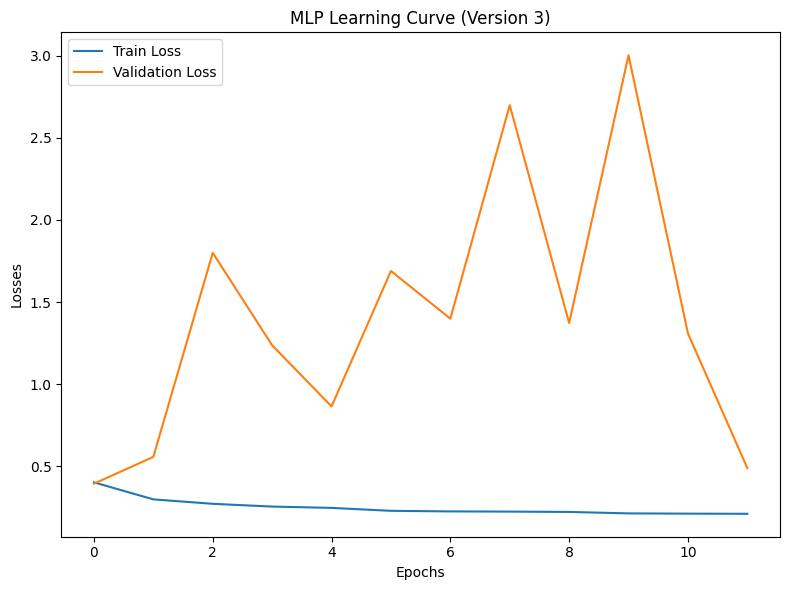

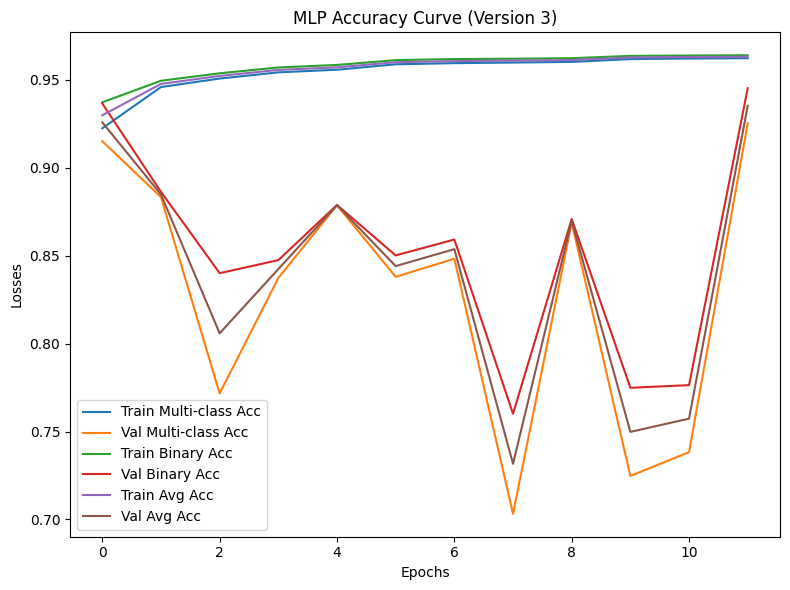

In [ ]:
# ploting the learning curves
plot_learning_curves(final_history, "MLP", "Version 3")

In [ ]:
# train the final model on the training data only
start = time.time()
mlp_classifier, final_history = train_final_model(
    model,
    train_loader,
    criterion_multi,
    criterion_binary,
    optimizer,
    40,
    device
)

measure_time((time.time()-start), "MLP")

Epoch [1/40], Train Loss: 0.2905, Train Acc Avg: 0.9488, Train Acc Multi: 0.9472, Train Acc Binary: 0.9503
Epoch [2/40], Train Loss: 0.2754, Train Acc Avg: 0.9507, Train Acc Multi: 0.9493, Train Acc Binary: 0.9520
Epoch [3/40], Train Loss: 0.2647, Train Acc Avg: 0.9523, Train Acc Multi: 0.9511, Train Acc Binary: 0.9536
Epoch [4/40], Train Loss: 0.2556, Train Acc Avg: 0.9541, Train Acc Multi: 0.9529, Train Acc Binary: 0.9553
Epoch [5/40], Train Loss: 0.2469, Train Acc Avg: 0.9560, Train Acc Multi: 0.9548, Train Acc Binary: 0.9571
Epoch [6/40], Train Loss: 0.2393, Train Acc Avg: 0.9576, Train Acc Multi: 0.9565, Train Acc Binary: 0.9587
Epoch [7/40], Train Loss: 0.2342, Train Acc Avg: 0.9586, Train Acc Multi: 0.9575, Train Acc Binary: 0.9597
Epoch [8/40], Train Loss: 0.2290, Train Acc Avg: 0.9595, Train Acc Multi: 0.9584, Train Acc Binary: 0.9606
Epoch [9/40], Train Loss: 0.2250, Train Acc Avg: 0.9601, Train Acc Multi: 0.9590, Train Acc Binary: 0.9612
Epoch [10/40], Train Loss: 0.2219, Tr

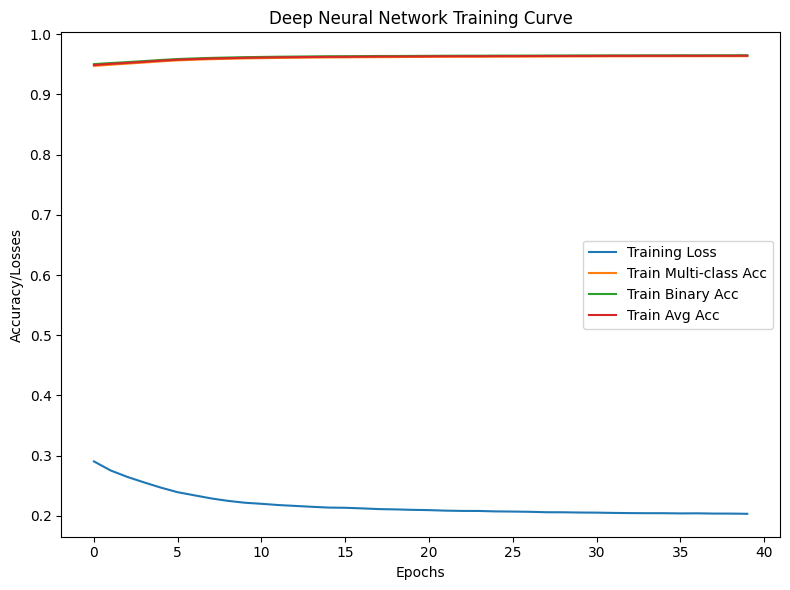

In [ ]:
# plot the final model training curve
plot_training_curve(final_history)

In [ ]:
# checking the model
summary(mlp_classifier, input_size=(1,input_size))

Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerPerceptron                     [1, 7]                    --
├─Sequential: 1-1                        [1, 448]                  --
│    └─Linear: 2-1                       [1, 448]                  12,992
│    └─BatchNorm1d: 2-2                  [1, 448]                  896
│    └─ReLU: 2-3                         [1, 448]                  --
│    └─Dropout: 2-4                      [1, 448]                  --
│    └─Linear: 2-5                       [1, 448]                  201,152
│    └─BatchNorm1d: 2-6                  [1, 448]                  896
│    └─ReLU: 2-7                         [1, 448]                  --
│    └─Dropout: 2-8                      [1, 448]                  --
│    └─Linear: 2-9                       [1, 448]                  201,152
│    └─BatchNorm1d: 2-10                 [1, 448]                  896
│    └─ReLU: 2-11                        [1, 448]                  -

                                        MLP REPORT          

                                    < === Accuracy & Loss Report === >

                       Multi-class  |   Binary   |   Average
Training Accuracy:       0.8728     |   0.8851   |   0.8790
Test Accuracy:           0.8724     |   0.8850   |   0.8787
                            -       |      -     |      -
Training Loss:           0.5457     |   0.4762   |   0.5110
Test Loss:               0.5456     |   0.4756   |   0.5110


                                 < === Binary Classification Report === >

Precision: 0.9488
Recall: 0.7852
F1 Score: 0.8593
True Positive Rate: 0.7852
False Positive Rate: 0.0343



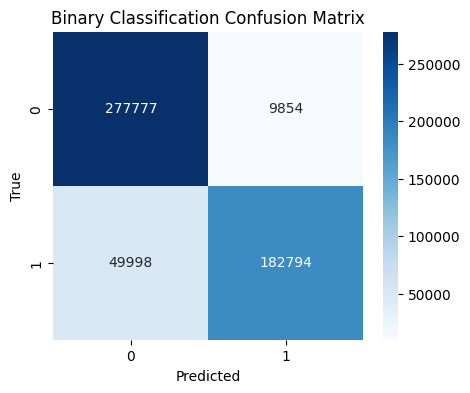

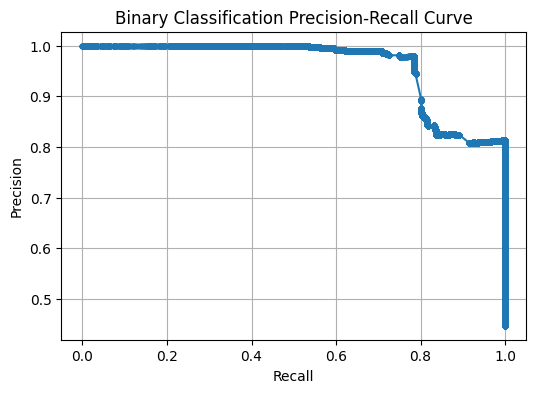



                           < === Multi-class Classification Report === >

Precision: 0.8873
Recall: 0.8724
F1 Score: 0.8469
True Positive Rate: 0.7851
False Positive Rate: 0.0373



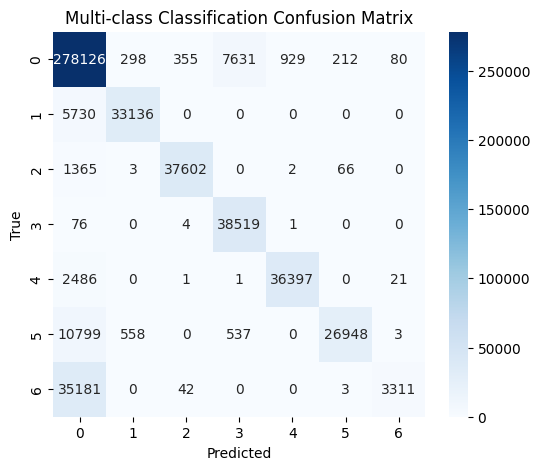

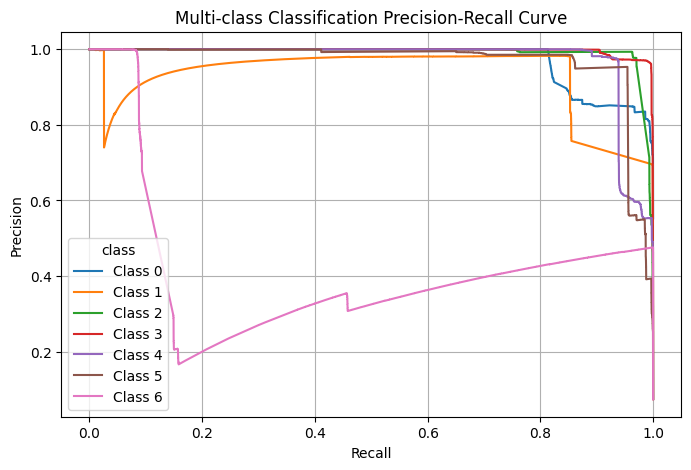



                               < === Average Classification Report === >

Precision: 0.9181
Recall: 0.8288
F1 Score: 0.8531
True Positive Rate: 0.7852
False Positive Rate: 0.0358


In [ ]:
# evaluate the final model on test set & get the loss and accuracy of training set
binary_classification_report_mlp, multi_classification_report_mlp, avg_classification_report_mlp = evaluate_dnn_result(mlp_classifier, "MLP", train_loader, test_loader, output_size, device)

In [ ]:
# write into json file
save_classification_reports(binary_classification_report_mlp, multi_classification_report_mlp, avg_classification_report_mlp, "MLP V3", (path + "v3_results.json"))

Data saved successfully!


In [ ]:
# saving model
torch.save(mlp_classifier, (path + "mlp_classifier_v3.pth"))
torch.save(mlp_classifier.state_dict(), (path + "mlp_classifier_states_v3.pth"))

# **This notebook was run on Google Colab, so there might be directory mismatch issues**